## Import

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import timm
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import psutil
import os
import platform
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

d:\Perkuliahan\Sem 7\Pembelajaran Mendalam\Week 12\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device Setup & Reproducibility

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

# Optional: set seeds
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

output_dir = "DeiT Tiny"
os.makedirs(output_dir, exist_ok=True)

✅ Using device: cuda


## Data Preparation

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_test = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    normalize
])

# Load datasets
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Data loaders
BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Test: {len(test_dataset)} images")

✅ Test: 10000 images


## Model Setup – Load Pretrained

In [4]:
# Load DeiT Tiny from timm (pretrained on ImageNet-1k)
print("📥 Loading DeiT Tiny from timm...")
model = timm.create_model(
    'deit_tiny_distilled_patch16_224.fb_in1k',
    pretrained=True,
    num_classes=10
)

# Freeze all but the head
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

model = model.to(device)
print("✅ Model output shape test:", model(torch.randn(1, 3, 224, 224).to(device)).shape)

📥 Loading DeiT Tiny from timm...
✅ Model output shape test: torch.Size([1, 10])


In [5]:
def get_model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024 ** 2)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params
model_size_mb = get_model_size_mb(model)

print("=== MODEL PARAMETER ===")
print(f"• Total Parameters:         {total_params:,}")
print(f"• Trainable Parameters:     {trainable_params:,}")
print(f"• Non-Trainable Parameters: {non_trainable_params:,}")
print(f"• Model Size (FP32):        {model_size_mb:.2f} MB")

=== MODEL PARAMETER ===
• Total Parameters:         5,528,660
• Trainable Parameters:     3,860
• Non-Trainable Parameters: 5,524,800
• Model Size (FP32):        21.09 MB


## Performance Metrics

✅ Saved figure to DeiT Tiny\samples.png


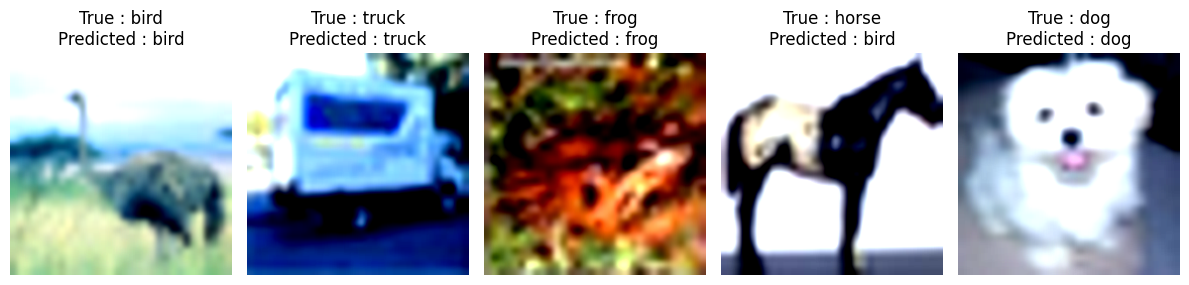

In [6]:
model_path = os.path.join(output_dir, "deit_tiny_cifar10_best.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Get predictions
all_preds, all_labels, all_images = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = probs.max(1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu())

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Convert to numpy arrays
all_images = torch.stack(all_images).numpy()
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Show 5 random samples
idxs = np.random.choice(len(all_labels), 5, replace=False)
plt.figure(figsize=(12, 4))
for i, idx in enumerate(idxs):
    img = np.transpose(all_images[idx], (1, 2, 0))  # C,H,W → H,W,C
    img = np.clip((img * 0.5 + 0.5), 0, 1)

    true_label = class_names[all_labels[idx]]
    pred_label = class_names[all_preds[idx]]

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True : {true_label}\nPredicted : {pred_label}")

plt.tight_layout()
save_path = os.path.join(output_dir, "samples.png")
plt.savefig(save_path, dpi=200, bbox_inches='tight')
print(f"✅ Saved figure to {save_path}")
plt.show()

In [7]:
# Save to CSV
df = pd.DataFrame({
    'image_id': list(range(len(all_labels))),
    'true_label': [class_names[i] for i in all_labels],
    'predicted_label': [class_names[i] for i in all_preds],
})
csv_path = os.path.join(output_dir, "predictions.csv")
df.to_csv(csv_path, index=False)
print("✅ Predictions saved to 'predictions.csv'")

✅ Predictions saved to 'predictions.csv'


In [8]:
acc = accuracy_score(all_labels, all_preds)
prec_macro = precision_score(all_labels, all_preds, average='macro')
rec_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print("\n=== PERFORMANCE METRICS ===")
print(f"• Overall Accuracy: {acc:.4f} ({100*acc:.2f}%)")
print(f"• Macro Precision:  {prec_macro:.4f}")
print(f"• Macro Recall:     {rec_macro:.4f}")
print(f"• Macro F1-Score:   {f1_macro:.4f}")

# Per-class
prec_per = precision_score(all_labels, all_preds, average=None)
rec_per = recall_score(all_labels, all_preds, average=None)
f1_per = f1_score(all_labels, all_preds, average=None)

print("\n• Per-Class Metrics:")
print("Class\t\tPrecision\tRecall\t\tF1")
for i, name in enumerate(class_names):
    print(f"{name:<12}\t{prec_per[i]:.4f}\t\t{rec_per[i]:.4f}\t\t{f1_per[i]:.4f}")


=== PERFORMANCE METRICS ===
• Overall Accuracy: 0.9189 (91.89%)
• Macro Precision:  0.9189
• Macro Recall:     0.9189
• Macro F1-Score:   0.9188

• Per-Class Metrics:
Class		Precision	Recall		F1
airplane    	0.9234		0.9280		0.9257
automobile  	0.9470		0.9470		0.9470
bird        	0.9322		0.8800		0.9053
cat         	0.8582		0.8410		0.8495
deer        	0.9005		0.9230		0.9116
dog         	0.8738		0.8860		0.8798
frog        	0.9277		0.9500		0.9387
horse       	0.9383		0.9280		0.9331
ship        	0.9495		0.9590		0.9542
truck       	0.9386		0.9470		0.9428


## Confusion Matrix

✅ Saved figure to DeiT Tiny\confusion.png


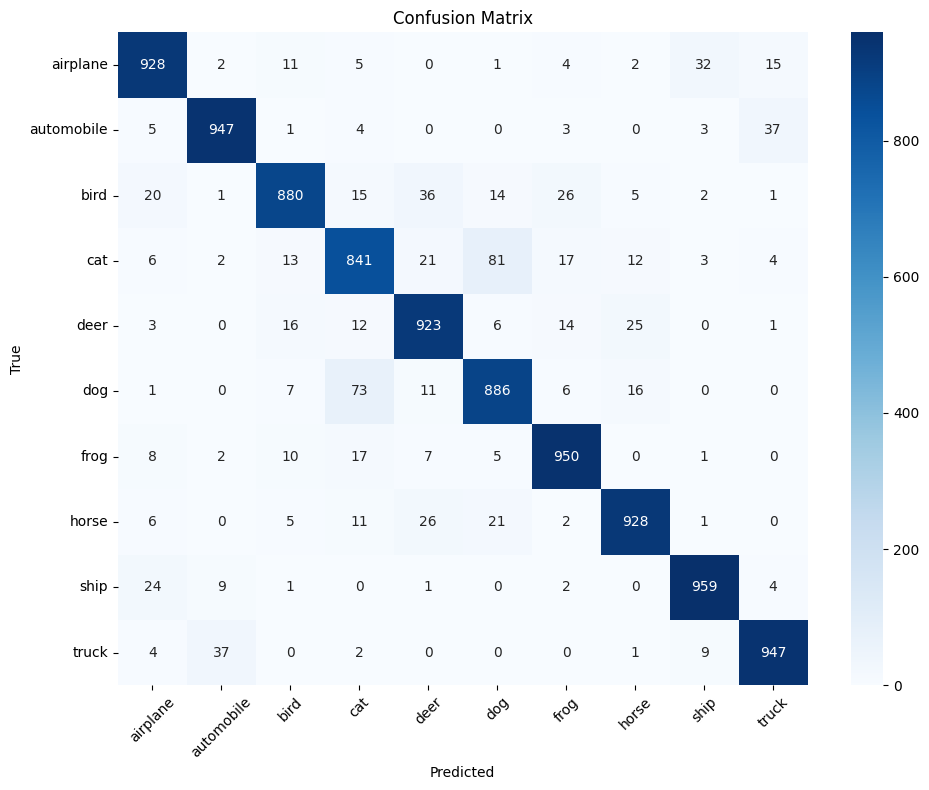

In [9]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
save_path = os.path.join(output_dir, "confusion.png")
plt.savefig(save_path, dpi=200, bbox_inches='tight')
print(f"✅ Saved figure to {save_path}")
plt.show()

## Inference

In [10]:
# Warm-up
model.eval()
with torch.no_grad():
    for _ in range(10):
        x, _ = next(iter(test_loader))
        x = x.to(device)
        _ = model(x)

# Timed inference on full test set
start_time = time.time()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        _ = model(x)
end_time = time.time()

total_time = end_time - start_time
total_images = len(test_dataset)
avg_time_per_image_ms = (total_time / total_images) * 1000
throughput = total_images / total_time

print("=== INFERENCE TIME ===")
print(f"• Total test images:       {total_images}")
print(f"• Total inference time:    {total_time:.3f} sec")
print(f"• Avg. time per image:     {avg_time_per_image_ms:.3f} ms")
print(f"• Throughput:              {throughput:.2f} images/sec")

# Hardware info
if torch.cuda.is_available():
    # NVIDIA GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f"• Hardware:                GPU - {gpu_name}")
elif torch.backends.mps.is_available():
    # Apple Silicon (M1/M2/M3)
    print("• Hardware:                Apple MPS (Metal Performance Shaders)")
else:
    # CPU fallback
    cpu_count = psutil.cpu_count(logical=False)
    cpu_name = platform.processor() or "Unknown CPU"
    print(f"• Hardware:                CPU - {cpu_name} ({cpu_count} cores)")

=== INFERENCE TIME ===
• Total test images:       10000
• Total inference time:    9.146 sec
• Avg. time per image:     0.915 ms
• Throughput:              1093.41 images/sec
• Hardware:                GPU - NVIDIA GeForce RTX 5060 Laptop GPU


## Attention Maps

✅ Saved figure to DeiT Tiny\attention.png


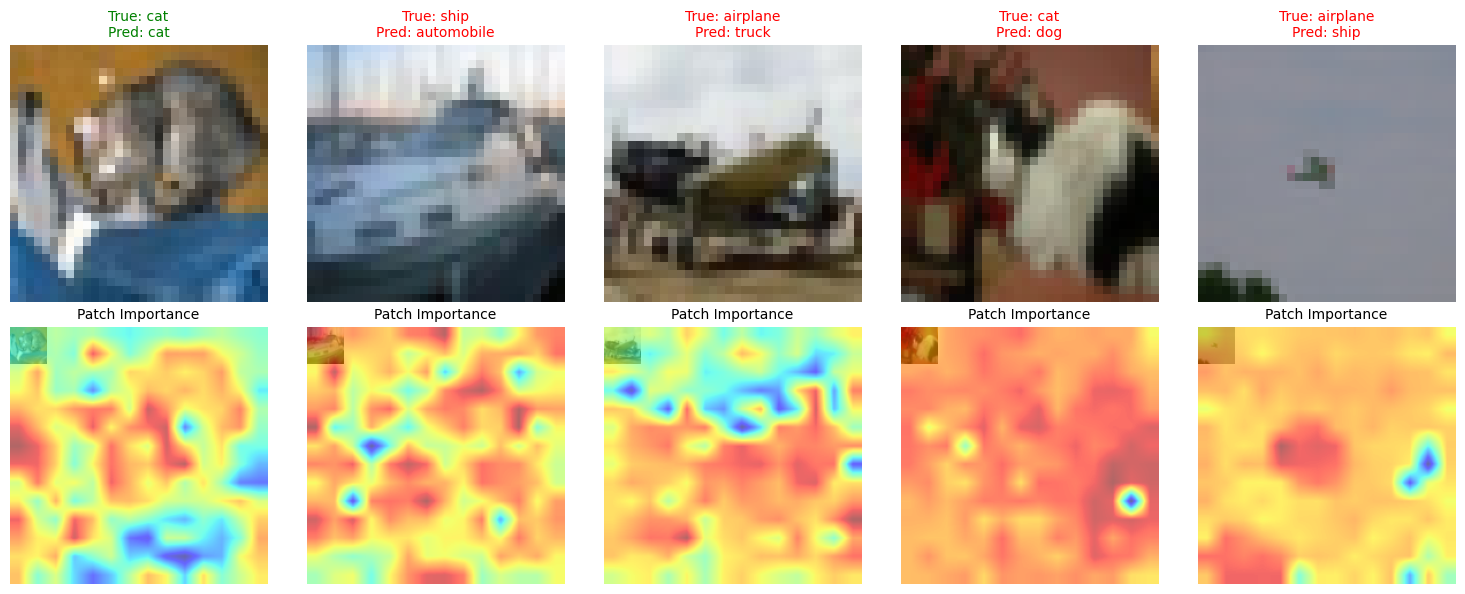

In [11]:
test_dataset_raw = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

indices = [0, 2, 74, 78, 97]
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    # Raw image
    img_raw, label = test_dataset_raw[idx]
    true_name = class_names[label]
    
    # Model input
    img_tf, _ = test_dataset[idx]
    img_tf = img_tf.unsqueeze(0).to(device)
    
    # Forward to get features
    with torch.no_grad():
        features = model.forward_features(img_tf)  # [1, 198, 192] for distilled DeiT
        output = model.forward_head(features)
        pred = output.argmax(1).item()
        pred_name = class_names[pred]
    
    # De-normalize for display
    img_disp = img_tf.cpu().squeeze().permute(1, 2, 0)
    img_disp = img_disp * std + mean
    img_disp = torch.clamp(img_disp, 0, 1)
    
    # Plot original
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_raw)
    color = 'green' if label == pred else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=10)
    plt.axis('off')
    
    # Extract patch tokens (skip CLS + DIST)
    patch_tokens = features[0, 2:]  # [196, 192]
    importance = patch_tokens.norm(dim=1).cpu().numpy()  # L2 norm

    num_patches = importance.shape[0]
    grid = int(math.sqrt(num_patches))
    importance = importance.reshape(grid, grid)
    importance = (importance - importance.min()) / (importance.max() - importance.min())
    
    # Upsample to image size
    attn_map = F.interpolate(
        torch.tensor(importance).unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode='bilinear'
    ).squeeze().numpy()
    
    # Overlay
    plt.subplot(2, 5, i + 6)
    plt.imshow(img_raw)
    plt.imshow(attn_map, cmap='jet', alpha=0.6)
    plt.axis('off')
    plt.title("Patch Importance", fontsize=10)

plt.tight_layout()
save_path = os.path.join(output_dir, "attention.png")
plt.savefig(save_path, dpi=200, bbox_inches='tight')
print(f"✅ Saved figure to {save_path}")
plt.show()